## Exercice 1 : Le Débruitage (Denoising)

**Objectif :** Apprendre au réseau à ignorer les artefacts pour reconstruire une image propre.

* **Dataset :** MNIST (rapide), CIFAR-10 ou Oxford Pets.
* **Méthode :** Vous devez injecter du bruit aléatoire dans vos images d'entrée tout en gardant les images originales comme cibles.
* **Code pour bruiter :** `x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)`

In [ ]:
# --- imput ---

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.layers import Input, Rescaling, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Conv2DTranspose



In [ ]:
# --- load dataset ---

(X_train, _),(X_test, y) = datasets.mnist.load_data()

# --- normalisation ---
X_train_output = X_train.astype("float32")/255.0
X_test_output = X_test.astype("float32")/255.0

In [ ]:
# --- add noise ---

noise_factor = 0.1

X_train_noisy = X_train_output + noise_factor * tf.random.normal(shape=X_train_output.shape)
X_test_noisy  = X_test_output  + noise_factor * tf.random.normal(shape=X_test_output.shape)

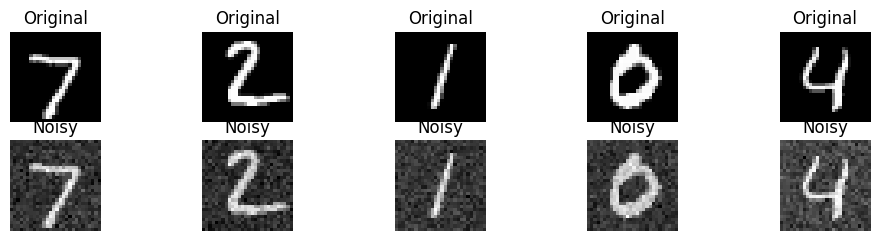

In [ ]:
# --- visualisation ---

n = 5  # image number 
plt.figure(figsize=(12, 4))
for i in range(n):
    # --- origin ---
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # --- niose ---
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[i].numpy().squeeze(), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")

plt.show()


In [ ]:
# --- encoder modeling --- 
input_img = Input(shape=(28,28,1), dtype='float32')
# entré 28*28*1 pixels = 784

x = Rescaling(1.0/255)(input_img)
# x = Reshape((28,28,1))(x)

# Encoder, réduction spatiale par convolutions
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
# Ici taille 28*28*32 = 25088
x = MaxPooling2D((2,2))(x)
# Ici taille 14*14*32 = 6272
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
# Ici taille 14*14*64 = 12544
x = MaxPooling2D((2,2))(x)
# Ici taille 7*7*64 = 3136

# compression
x = Flatten()(x) # 7*7*64 = 3136
latent = Dense(32, activation='relu', name='latent')(x) 
# Signal fait 32

# Decoder 
x = Dense(7*7*64, activation='relu')(latent) # 32 -> 3136
x = Reshape((7,7,64))(x) # Ici taille 7*7*64 = 3136

x = Conv2DTranspose(64, (3,3), strides=2,activation='relu', padding='same')(x)
# Ici taille 14*14*64 = 12544
x = Conv2DTranspose(32, (3,3), strides=2,activation='relu', padding='same')(x)
# Ici taille 28*28*32 = 25088

decoder = Conv2D(1 , (3,3), activation='sigmoid', padding='same')(x)
# Ici taille 28*28*1 = 784
# 1 seul neuronne car on veut une image noir et blanc 2D

autoencoder = models.Model(input_img, decoder)
autoencoder.compile(optimizer="adam", loss="mse", metrics=["mse"])
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 32)             │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3136)           │       103,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,369 (1.06 MB)

 Trainable params: 278,369 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- autoencoder fitting ---

autoencoder.fit(
    X_train_noisy,   # ВХОД → шумные изображения
    X_train_output,         # TARGET → чистые изображения
    epochs=10,
    batch_size=128,
    validation_data=(X_test_noisy, X_test_output)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 0.0744 - mse: 0.0744 - val_loss: 0.0675 - val_mse: 0.0675
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - loss: 0.0627 - mse: 0.0627 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0268 - mse: 0.0268 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0174 - val_mse: 0.0174
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0154 - mse: 0.0154 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


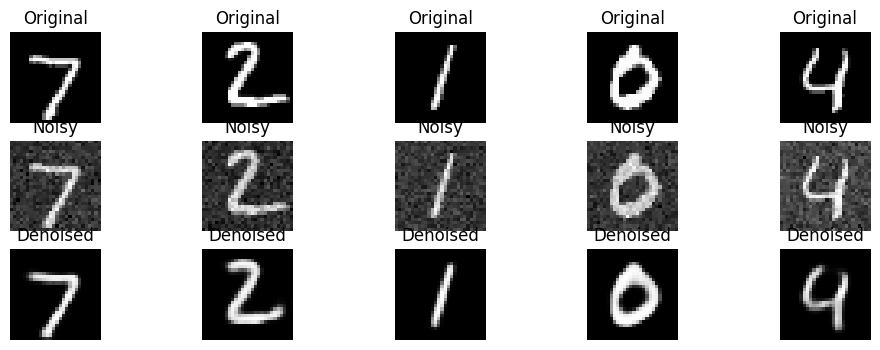

In [ ]:
# --- visualisation result ---

decoded_imgs = autoencoder.predict(X_test_noisy[:n])

plt.figure(figsize=(12, 4))
for i in range(n):

    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")


    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[i].numpy().squeeze(), cmap="gray")
    plt.title("Noisy")
    plt.axis("off")


    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
    plt.title("Denoised")
    plt.axis("off")

plt.show()
